# Deep Learning Notebook - UNet
The example here uses publicly available COVID-19 images with masks for segmenting lungs from CT images (http://medicalsegmentation.com/covid19/). Images and masks are in NIfTI files (.nii) that will be unpackaged using SimpleITK and transformed to NumPy arrays. 


## Install dependencies

In [1]:
!pip install -r requirements.txt

## Import packages

In [2]:
import os
import multiprocessing
import glob
from tqdm.notebook import trange, tqdm

import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, BatchNormalization, Cropping2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.backend import int_shape
from tensorflow.keras.metrics import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *

import numpy as np
import SimpleITK as sitk
from sklearn.model_selection import train_test_split
from skimage import filters, transform
import matplotlib.pyplot as plt

from utils.notebook_utils import *


## Preprocess images
The workflow will vary depending on the size of the library, data type, training method, and task. For this example, we will be separating NIfTI files into their component images, resizing, and filtering for noise reduction.

### Define some functions

In [3]:
def getFileList(image_path, mask_path):
    """
    Index available Nifti files
    """
    if image_path[-1] != '/':
        image_path = image_path + '/'

    if mask_path[-1] != '/':
        mask_path = mask_path + '/'

    image_list = glob.glob(image_path +'*.nii')
    mask_list = glob.glob(mask_path + '*.nii')

    file_list = list(zip(image_list, mask_list))
    print(f'Found {len(file_list)} Nii files')
    
    return file_list


def niftiToFlowArray(file_list, image_height, image_width):
    """
    Process a list of Nifti files and return two Rank 4 Numpy arrays
    for using the Keras ImageDataGenerator.flow() method
    """
    image_batch = []
    for file_zip in file_list:
        nifti_num = int(file_zip[0].replace('.nii','')[-1])
        image_batch.append(parallelSlices(file_zip, nifti_num, image_height, image_width))
    
    image_array, mask_array = createFlowArray(image_batch, image_height, image_width)
    
    return image_array, mask_array
        

def parallelSlices(file_zip, nifti_num, image_height, image_width):
    """
    Iterating through the slices of each Nifti file one at a time is very slow.
    This processes the slices in parallel and returns a list of dictionaries,
    where each dictionary contains the results from a single Nifti file.
    """
    manager = multiprocessing.Manager()
    image_batch = manager.dict()
    jobs = []
    
    image = sitk.ReadImage(file_zip[0])
    mask = sitk.ReadImage(file_zip[1])
    for i in range(image.GetSize()[2]):
        p = multiprocessing.Process(target=findSlicesWithMasks, args=(i, nifti_num, image, mask, image_batch, image_height, image_width))
        jobs.append(p)
        p.start()

    for j, proc in enumerate(tqdm(jobs)):
        proc.join()
        
    return image_batch


def findSlicesWithMasks(ind, nifti_num, img, mask, image_batch, image_height, image_width):
    """
    This returns images which have corresponding masks as a single array
    """
    mask_slice = mask[:,:,ind]
    if max(mask_slice) > 0:
        img_slice = img[:,:,ind]
        img_slice = (img_slice - min(img_slice))/(max(img_slice) - min(img_slice))
        img_slice = sitk.GetArrayFromImage(img_slice)
        img_slice = np.reshape(img_slice, (1, image_height, image_width, 1))
        img_slice = img_slice.astype(dtype='float32')
        mask_slice = sitk.GetArrayFromImage(mask_slice)
        mask_slice = np.reshape(mask_slice, (1, image_height, image_width, 1))
        mask_slice = mask_slice.astype(dtype='float32')
        image_batch[ind] = (nifti_num, ind, img_slice, mask_slice)
        
    return image_batch
        
    
def createFlowArray(image_batch, image_height, image_width, num_channels=1):
    """
    Batch indices:
    0: Nifti file number
    1: Slice number
    2: Image array
    3: Mask array

    Create a Rank 4 numpy array each for images and masks
    (batch size, height, width, channels=1)
    """
    image_array = np.empty(shape=(1, image_height, image_width, num_channels), dtype='float32')
    mask_array = np.empty(shape=(1, image_height, image_width, num_channels), dtype='float32')
    for nifti in image_batch:
        for entry in nifti.values():
            image_array = np.append(image_array, entry[2], axis=0)
            mask_array = np.append(mask_array, entry[3], axis=0)
            
    image_array = np.delete(image_array, 0, 0)
    mask_array = np.delete(mask_array, 0, 0)
                
    return image_array, mask_array


# train_unet.py - Resize images (630 x 630 -> 512 x 512) and median filter to reduce noise
def resizeDataArrays(image_data_array, mask_data_array, output_height=512, output_width=512):
    # Create temporary arrays
    resized_image_array = np.ndarray(shape=(image_data_array.shape[0], 512, 512, 1), dtype='float32')
    resized_mask_array = np.ndarray(shape=(mask_data_array.shape[0], 512, 512, 1), dtype='float32')
    
    for i in trange(image_data_array.shape[0]):
        # Resize to 512 x 512
        resized_image_array[i,:,:,0] = transform.resize(image_data_array[i,:,:,0], (output_height,output_width), anti_aliasing=True)
        resized_mask_array[i,:,:,0] = transform.resize(mask_data_array[i,:,:,0], (output_height,output_width), anti_aliasing=True)

        # Median filter to clean up images
        resized_image_array[i,:,:,0] = filters.median(resized_image_array[i,:,:,0])
        
    return resized_image_array, resized_mask_array



### Find available Nii files

In [4]:
image_path = '/home/moopers/Downloads/ct_data/rp_im/'
mask_path = '/home/moopers/Downloads/ct_data/rp_lung_msk/'
print('Populating file list')
file_list = getFileList(image_path, mask_path)


Populating file list
Found 9 Nii files


### Convert NIfTI stacks to NumPy arrays and resize
This process is done in parallel to save time, but it still can take ~30 min depending on the number of CPUs the cluster has. The cells below give the option to save/load the output arrays as '.npy' files to skip this step for future use.

In [5]:
# Convert Nii stacks to rank 4 numpy array (batch size, height, width, channels) to use
# Keras ImageDataGenerator.flow() method
print('Converting Nii files to Numpy array')
image_data_array, mask_data_array = niftiToFlowArray(file_list, image_height=630, image_width=630)

# Resize images to 512 x 512
print('Resizing images to 512 x 512')
image_data_array, mask_data_array = resizeDataArrays(image_data_array, mask_data_array, output_height=512, output_width=512)


Converting Nii files to Numpy array



Resizing images to 512 x 512


In [6]:
# Save NumPy arrays to file
save_array = True
    
if save_array is True:
    with open('images.npy', 'wb') as f1:
        np.save(f1, image_data_array)

    with open('masks.npy', 'wb') as f2:
        np.save(f2, mask_data_array)

In [16]:
# Load NumPy arrays from file
load_array = True

if load_array is True:
    with open('images.npy', 'rb') as f1:
        image_data_array = np.load(f1)

    with open('masks.npy', 'rb') as f2:
        mask_data_array = np.load(f2)

### Create training/testing sets

In [17]:
# Split into training/testing sets
print('Splitting image sets into train/test...')
x_train, x_test, y_train, y_test = train_test_split(image_data_array, mask_data_array, test_size=0.33, random_state=42)
print('Done')

Splitting image sets into train/test...
Done


In [18]:
# Instantiate data generators
print('Creating data generators...')
data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=90,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2)

image_datagen = ImageDataGenerator()
mask_datagen = ImageDataGenerator()

# Provide the same seed and keyword arguments to the fit and flow methods
# for data and masks so they stay paired
seed = 1
batch_size = 8 # This will depend on how much GPU memory, default=8
image_datagen.fit(x_train, augment=False, seed=seed)
mask_datagen.fit(y_train, augment=False, seed=seed)

image_generator = image_datagen.flow(x_train, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(y_train, batch_size=batch_size, seed=seed)
train_generator = zip(image_generator, mask_generator)
print('Done')


Creating data generators...
Done


### Define model
This model is adapted from https://github.com/karolzak/keras-unet. The model allows for a custom number of encoder filters, inclusion of additional dropout layers, and optional batch normalization.

In [19]:
# UNet Keras implementation
def unet(
    metrics, # No default value; must be defined as part of the MirroredStrategy to use multiple GPUs
    input_height=512, 
    input_width=512, 
    input_channels=1, # Grayscale = 1, color = 3 for RGB 
    num_classes=1, 
    dropout=0.5, 
    filters=64, 
    output_activation='sigmoid', # 'sigmoid' or 'softmax'
    weights_path=None, # Load weights for model from file
    loss='binary_crossentropy',
    optimizer=SGD(lr=0.01, momentum=0.99),
    num_layers=4
): 
    # Create input from dimensions
    input_shape = (input_height, input_width, input_channels)
    inputs = Input(input_shape)
    x = inputs   

    down_layers = []
    for l in range(num_layers):
        x = conv2d_block(inputs=x, filters=filters)
        down_layers.append(x)
        x = MaxPooling2D((2, 2), strides=2) (x)
        filters = filters*2 # double the number of filters with each layer

    x = Dropout(dropout)(x)
    x = conv2d_block(inputs=x, filters=filters)

    for conv in reversed(down_layers):
        filters //= 2 # decreasing number of filters with each layer 
        x = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)       
        ch, cw = get_crop_shape(int_shape(conv), int_shape(x))
        conv = Cropping2D(cropping=(ch, cw))(conv)
        x = Concatenate()([x, conv])
        x = conv2d_block(inputs=x, filters=filters)
    
    outputs = Conv2D(num_classes, (1, 1), activation=output_activation)(x)    
    model = Model(inputs=[inputs], outputs=[outputs])

    if weights_path:
        model.load_weights(weights_path)

    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    return model


def conv2d_block(
    inputs,
    use_batch_norm=False,
    dropout=0.0,
    filters=64,
    kernel_size=(3,3),
    activation='relu',
    kernel_initializer='he_normal',
    padding='same'
):
    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm
    )(inputs)

    if use_batch_norm:
        c = BatchNormalization()(c)

    if dropout > 0.0:
        c = Dropout(dropout)(c)

    c = Conv2D(
        filters,
        kernel_size,
        activation=activation,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=not use_batch_norm
    )(c)

    if use_batch_norm:
        c = BatchNormalization()(c)

    return c


def get_crop_shape(target, refer):
    # width, the 3rd dimension
    cw = target[2] - refer[2]
    assert (cw >= 0)
    if cw % 2 != 0:
        cw1, cw2 = int(cw/2), int(cw/2) + 1
    else:
        cw1, cw2 = int(cw/2), int(cw/2)
    
    # height, the 2nd dimension
    ch = target[1] - refer[1]
    assert (ch >= 0)
    if ch % 2 != 0:
        ch1, ch2 = int(ch/2), int(ch/2) + 1
    else:
        ch1, ch2 = int(ch/2), int(ch/2)

    return (ch1, ch2), (cw1, cw2)


### Create a Mirrored Strategy
Running a model with a Tensorflow MirroredStrategy allows the model to be trained across multiple GPUs. It is still compatible with single GPU or CPU training, so this code can be run on any cluster. The amount of memory (RAM or GPU) available will affect the available batch size.   

In [20]:
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


### Build or load model

In [21]:
# Path to the model
model_path = None

# Open a strategy scope.
with strategy.scope():
    # Define metrics
    metrics = [MeanIoU(num_classes=2)]
    
    # Instantiate model
    if model_path:
        print('Loading model...')
        model = tf.keras.models.load_model(model_path)
        print('Done')
    else:
        print('Building UNet...')
        model = unet(metrics)
        print('Done')

Building UNet...
Done


### Train model

In [23]:
epoch_steps = x_train.shape[0]/batch_size
epochs = 10

if model_path is None:
    model_path = 'unet.h5'

# Train the model
print('Training model')
model_checkpoint = ModelCheckpoint(model_path, monitor='loss', verbose=1, save_best_only=True)
H = model.fit(train_generator, steps_per_epoch=epoch_steps, epochs=epochs, callbacks=model_checkpoint)

# Save loss history
loss_history = np.array(H.history['loss'])
np.savetxt("loss_history.csv", loss_history, delimiter=",")


Training model
Epoch 1/10
60/59 [==============================] - ETA: 0s - loss: 0.2976 - mean_io_u_1: 0.4409
Epoch 00001: loss improved from inf to 0.29760, saving model to unet.h5
60/59 [==============================] - 40s 671ms/step - loss: 0.2976 - mean_io_u_1: 0.4409
Epoch 2/10
60/59 [==============================] - ETA: 0s - loss: 0.2115 - mean_io_u_1: 0.4389
Epoch 00002: loss improved from 0.29760 to 0.21146, saving model to unet.h5
60/59 [==============================] - 41s 679ms/step - loss: 0.2115 - mean_io_u_1: 0.4389
Epoch 3/10
60/59 [==============================] - ETA: 0s - loss: 0.1810 - mean_io_u_1: 0.4410
Epoch 00003: loss improved from 0.21146 to 0.18099, saving model to unet.h5
60/59 [==============================] - 41s 687ms/step - loss: 0.1810 - mean_io_u_1: 0.4410
Epoch 4/10
60/59 [==============================] - ETA: 0s - loss: 0.1180 - mean_io_u_1: 0.4398
Epoch 00004: loss improved from 0.18099 to 0.11800, saving model to unet.h5
60/59 [===========

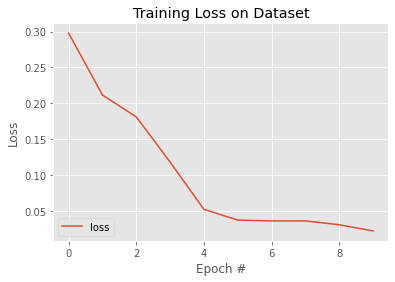

In [25]:
# plot the training loss and accuracy
N = epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

### Test model

In [27]:
# Test the model
test_datagen = ImageDataGenerator()
test_datagen.fit(x_test)
test_generator = test_datagen.flow(x_test, y_test, batch_size=4)

test_results = model.evaluate(test_generator)


59/59 [==============================] - 6s 109ms/step - loss: 0.0263 - mean_io_u_1: 0.4431


### Predict

In [28]:
# Evaluate the model
# TODO: replace x_test (Covid images) with COPDGene images, move to separate script
predict_results = model.predict(x_test, batch_size=10, verbose=1)

24/24 [==============================] - 7s 283ms/step


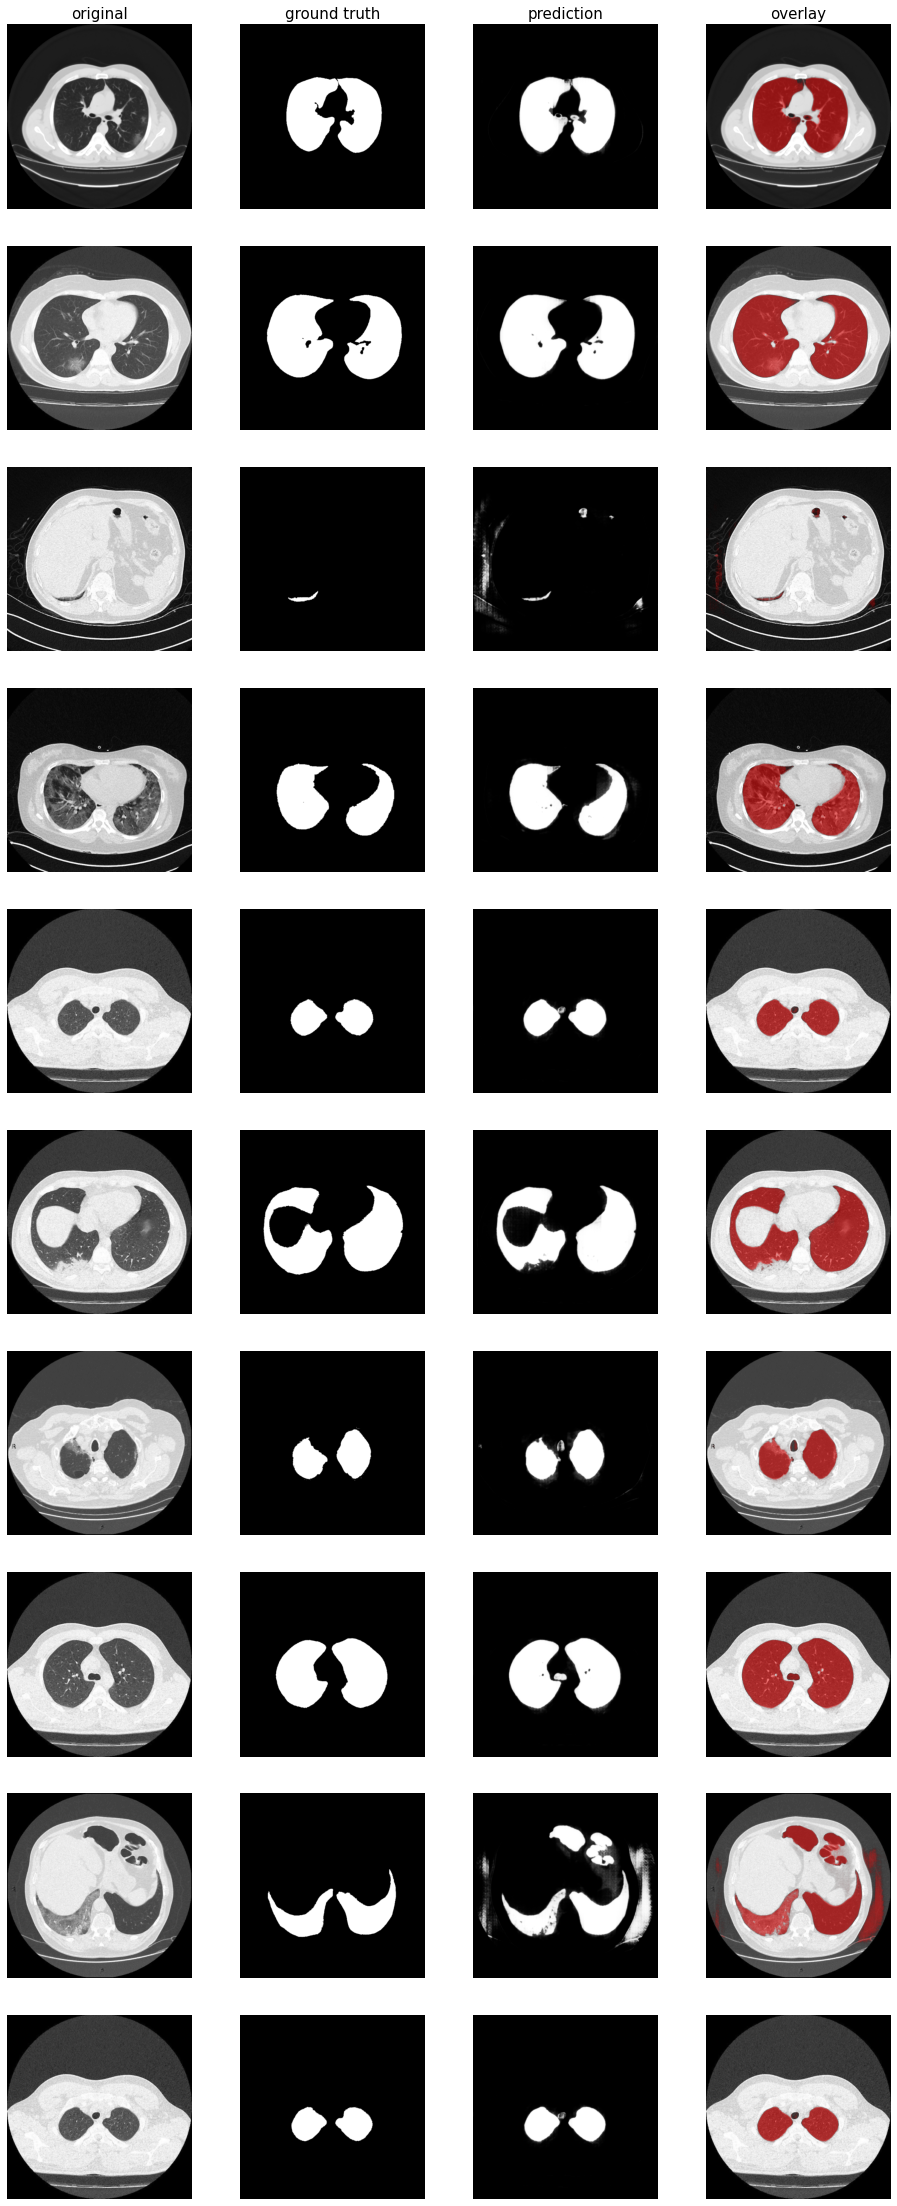

In [29]:
plot_imgs(org_imgs=x_test, mask_imgs=y_test, pred_imgs=predict_results, nm_img_to_plot=10)

In [30]:
from numba import cuda
cuda.select_device(0)
cuda.close()